In [2]:
from ADMCode import visualize as vis
from ADMCode import ddm

# Core Simulation Function

In [140]:
@jit(nb.typeof((1.0, 1))(float64[:], float64[:], float64[:]), nopython=True)
def sim_ddm_trace(rProb, trace, parameters):

    a, tr, vProb, zStart, si, dx, dt = parameters
    
    evidence = zStart
    trace[0] = evidence
    deadline = trace.size
    
    for nsteps in range(1, deadline):
        if rProb[nsteps] < vProb:
            evidence += dx
        else:
            evidence -= dx
        trace[nsteps] = evidence

        if evidence >= a:
            return tr + (nsteps * dt), 1     
        elif evidence <= 0:
            return tr + (nsteps * dt), 0
        
    return -1.0, -1

# Define Parameters

In [199]:
a = .15 #boundary height
v = .24 # drift-rate
v2 = .12
tr = .25 # nondecision time
z = .5 # starting point ([0,1], fraction of a)

dt = .001 # time step
si = .1 # sigma (noise scalar)
deadline = 1.75 # max decision time

ntrials = 250 # number of trials to simulate
data = np.zeros((ntrials, 2)) # empty matrix Ntrials x 2 (cols for RT & Choice)
data[:, 1] += 1000

data2 = np.zeros((ntrials, 2)) # empty matrix Ntrials x 2 (cols for RT & Choice)
data2[:, 1] += 1000

# Run Simulations

In [200]:
parameters, rProb, traces = ddm.gen_ddm_storage_objects(a, tr, v, z, si=si, dt=dt, 
                                           ntrials=ntrials, deadline=deadline)

for t in range(ntrials):
    data[t, :] = ddm.sim_ddm_trace(rProb[t], traces[t], parameters)
    if data[t, 0]<0:
        data[t, :] = -1, -1

In [201]:
parameters2, rProb2, traces2 = ddm.gen_ddm_storage_objects(a, tr, v2, z, si=si, dt=dt, 
                                           ntrials=ntrials, deadline=deadline)

for t in range(ntrials):
    data2[t, :] = ddm.sim_ddm_trace(rProb2[t], traces2[t], parameters2)
    if data2[t, 0]<0:
        data2[t, :] = -1, -1

## Filter Output Data

In [202]:
df, trace = ddm.clean_output(data, traces, deadline=deadline)
df2, trace2 = ddm.clean_output(data2, traces2, deadline=deadline)

## Plot simulations

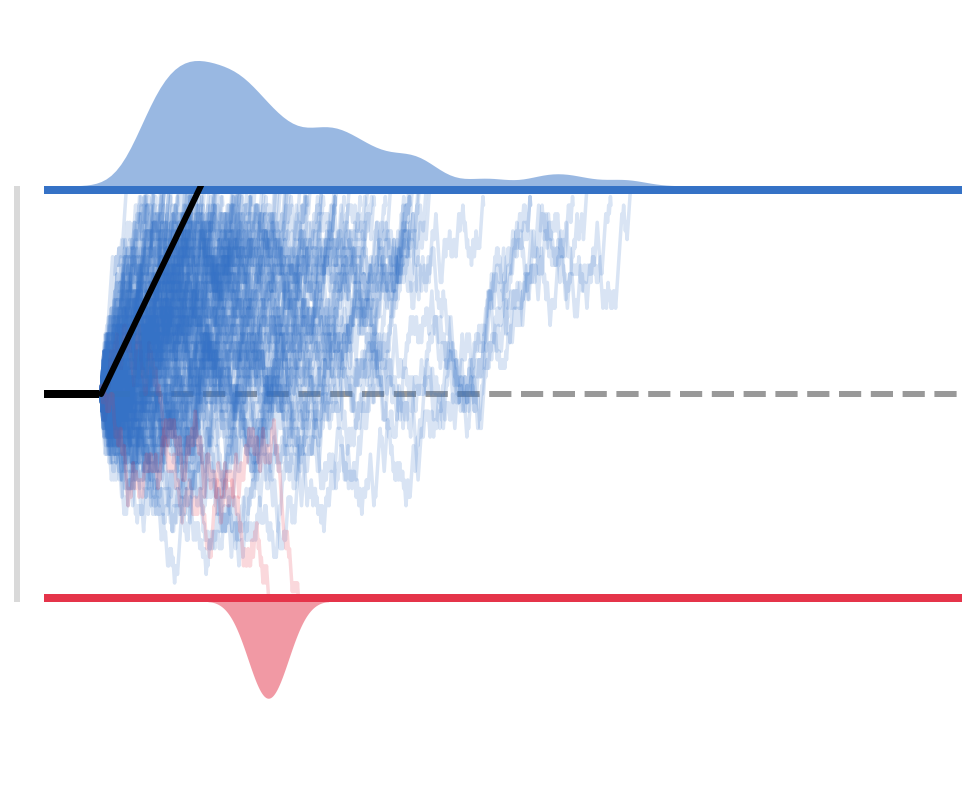

In [208]:
ax = vis.plot_ddm_traces(df, trace, parameters, plot_v=True)

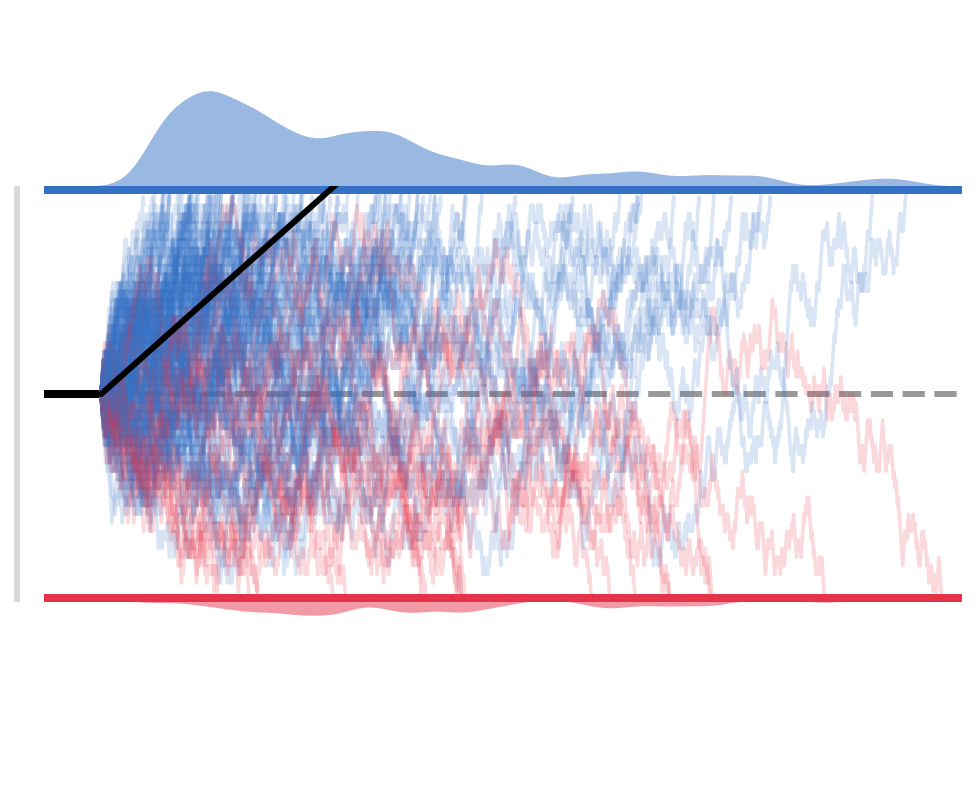

In [207]:
ax = vis.plot_ddm_traces(df2, trace2, parameters2, plot_v=True)

# Compare $v$ and $v_2$ RTs 

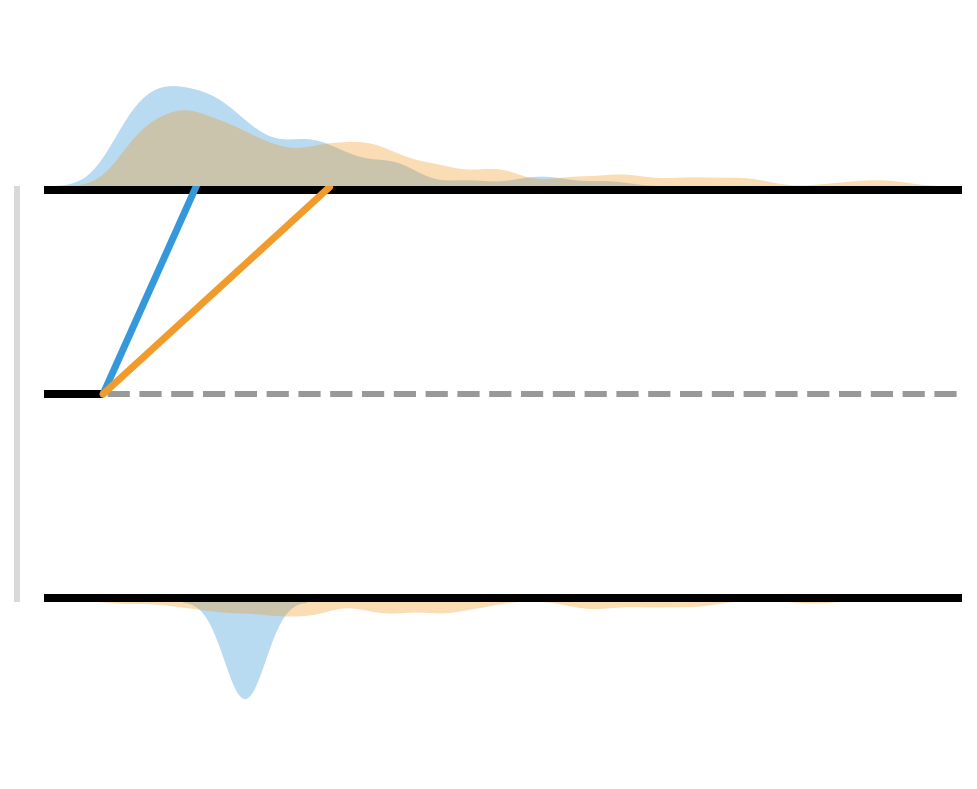

In [206]:
ax = vis.compare_drift_effects([df, df2], [parameters, parameters2], deadline=deadline)